<a href="https://colab.research.google.com/github/akshaysravindran/Tutorial_keras_tensorflow_CNN_interpretability/blob/main/Interpretable_CNN_EEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Interpretable Convolutional Neural Network for EEG Analysis**

## Install the required packages
This jupyter notebook is intended to serve as a tutorial to guide you through different ways to explain the convolutional neural network model (CNN) applied for electroencephalography analysis. The tutorial will cover the following segments

1) Training the model in keras<br>
2) Creating your CNN model<br>
3) Visualizing/ explainig the features learnt by the model using <br>


*   Occlussion Sensitivity
*   Activation Maximization
*   Grad-Class Activation Map


<br><br>
The tutorial is based on the sample data provided throughout the workshop series. Here the EEG data is collected from a volunteer who performed about 10 repetitions of eyes open and eyes closed lasting about 10 seconds each. The trials were alternating in betweem. The data used here is already preprocessed and segmented into training and tuning set.
<br><br>

Please ensure *Dataset.mat* and *dataset.png* files sent as email (unzip first) is saved inside your local google drive under a folder called *uhbmi_workshop*<br><br>

**Note:** <br>



*   The code uses earlier versions of multiple packages (keras, tensorflow) due to compatability issues with keras-vis package. There is a recent package developed to work with the latest version of keras and tensorflow libraries by another group. However, these are still being developed and the activization maximisation had some glitches and needs exploration still. The dependencies are added in here so it should ideally run unless future back compatibility issues arise

*   Here, gradCAM using the keras-vis package evaluates per image basis which is extremely slow.

*   Some of the plotting features in google colab behaves differently, for e.g. plotting colorbar for MNE generated images is being showed as an extra subplot. Therefore, those lines are commented out in this version  as the issue is not diagnosed. These will work locally if you install the required packages in anaconda and run your code there.

In [1]:

%%capture
if 1:
  # Keras is running on top of tensorflow
  !pip install tensorflow-gpu==1.15  # GPU
  # Keras vis package for implementing the visualization methods
  !pip install -U -I git+https://github.com/raghakot/keras-vis.git
  # Library to plot EEG data 
  !pip install mne --upgrade
  
  # Downgrade to a lower version of keras
  !pip install keras=='2.3.1'
  !pip install matplotlib==2.2.3.
  !pip install scipy==1.1.0
  !pip install 'h5py<3.0.0'

  

### Mount the google drive so that you can access the data saved there

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import the required libraries

In [3]:

#%%
#!pip uninstall matplotlib


# General functions
import numpy as np
import scipy.io as sio
from scipy import signal
from matplotlib import pyplot as plt
from matplotlib import rcParams
from sklearn.metrics import  f1_score, precision_score, recall_score
import mne
import matplotlib.image as mpimg

# Keras functions
from keras.models import Model
from keras import regularizers, activations
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers.convolutional import Conv2D,  MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical   

# Functions for visualization
from vis.visualization import visualize_cam, visualize_activation
from vis.utils import utils 


Using TensorFlow backend.


## Loading the data

Make sure the required files are in the uhbmi_workshop folder in your google drive<br>


1.   EEG should be in the format (number_of_examples x window_length x channels)
<br>
* Here we use EEG of 28 channels each window being 2.5 seconds long; Currently not using a test set as the purpose of this tutorial is just to show the implementation of the techniques and not reporting the accuracy and the example dataset is of small overall duration
2.   Labels are in integers format <br>
    *   0: Class 1 (eyes open) <br>
    *   1: Class 2  (eyes closed)<br>


 

The training and tuning set shapes are: 
(10038, 250, 28) (4352, 250, 28)
[0 0 0 ... 1 1 1] [0 0 0 ... 1 1 1]
Loaded the data


[]

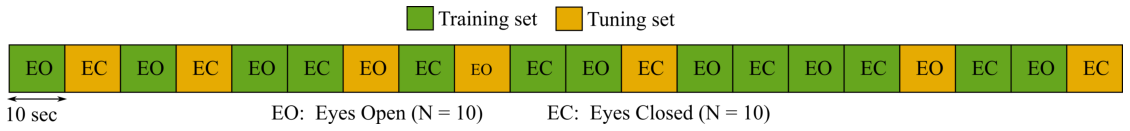

In [4]:
#%% Loading and preparing the data
import os
os.chdir("/content/drive/My Drive/uhbmi_workshop")
Loaded_data = sio.loadmat('Dataset.mat') #load data in matlab format   
 
# Extract training and validation EEG    
X_train     = Loaded_data['Training_set' ] 
X_valid     = Loaded_data['Tuning_set']  

# Extract training and validation labels 
Y_train     = Loaded_data['Train_Y' ]  
Y_train     = np.ravel(Y_train) 

Y_valid     = Loaded_data['Tuning_set_Y' ]
Y_valid     = np.ravel(Y_valid)

chanlocs     = Loaded_data['chanlocs' ] # EEG Channels
print('The training and tuning set shapes are: ')
print(np.shape(X_train), np.shape(X_valid)) # show the dimension of the data
print(Y_train, Y_valid)

print('Loaded the data')

# Display the original data structure and how data was partitioned
plt.figure(figsize=(20, 5))
plt.imshow(mpimg.imread('dataset.png'))
plt.box(False)
frame1       = plt.gca()
frame1.axes.yaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticks([])
frame1.axes.xaxis.set_ticklabels([])
frame1.axes.xaxis.set_ticks([])


## Data visualizing

Understand the data being classified prior to developing the model <br>
* Visualize one example data from each  class in raw data format
* Plot the mean PSD and topoplot in alpha band

Text(0.5, 1.0, 'Eyes Closed Example')

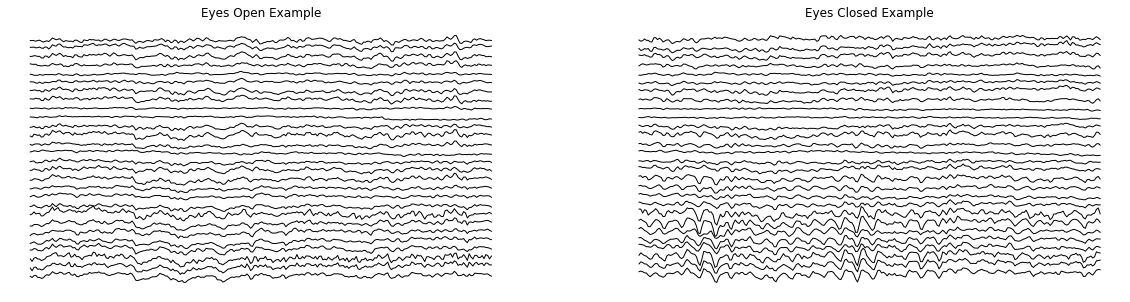

In [5]:
#%% Plot two sample inputs from either classes
 
ch,example_ID                         = 28,10
example_c0                 = X_train[example_ID].copy()
example_c1                 = X_train[-example_ID].copy()

offset                     = np.max(abs(example_c0))
for i in range(ch):
    example_c0[:,i]        =  example_c0[:,i]-(i*offset)  
    example_c1[:,i]        =  example_c1[:,i]-(i*offset)  
    
    
plt.figure(figsize=(20, 5))

ax1                       = plt.subplot(121)
plt.plot(example_c0,color = 'k',linewidth = 1)
plt.box(False)
frame1                    = plt.gca()
frame1.axes.yaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticks([])
frame1.axes.xaxis.set_ticklabels([])
frame1.axes.xaxis.set_ticks([])
plt.title('Eyes Open Example')

ax1                       = plt.subplot(122)
plt.plot(example_c1,color = 'k',linewidth = 1)
plt.box(False)
frame1                    = plt.gca()
frame1.axes.yaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticks([])
frame1.axes.xaxis.set_ticklabels([])
frame1.axes.xaxis.set_ticks([])
plt.title('Eyes Closed Example')



1.   Plot the mean power spectral density in the parietal and occipital channels for the same set of examples

2.   Plot the alpha power difference between examples using a topoplot



/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1773: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  .format(nperseg, input_length))


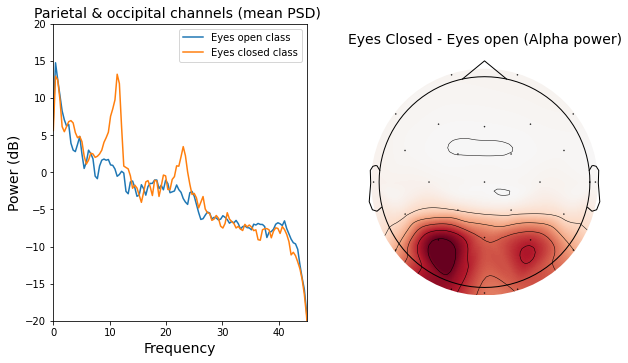

In [6]:
# Plot the PSD and the topoplot for alpha band power
NFFT           = 256
psd_all        = np.zeros((len(X_valid), NFFT//2+1,ch) ) 

# Compute PSD
for i in range(len(X_valid)):
    for chan in range(ch):
        freqs, psd_all[i,:,chan]    = signal.welch(X_valid[i,:,chan], fs=100., window='hann', nfft=NFFT)

class0_loc   = np.where(Y_valid  ==0)[0]
class1_loc   = np.where(Y_valid  ==1)[0]

fig          = plt.figure(figsize=(10, 5))
ax1          = plt.subplot(1,2,1)
plt.plot(freqs, 10*np.log10(np.mean(np.mean(psd_all[class0_loc,:,-8:],axis=2),axis=0)))         
plt.plot(freqs, 10*np.log10(np.mean(np.mean(psd_all[class1_loc,:,-8:],axis=2),axis=0)))
plt.xlim([0,45])
plt.ylim([-20,20])
plt.title('Parietal & occipital channels (mean PSD) ', fontsize = 14)
plt.xlabel('Frequency', fontsize = 14)
plt.ylabel('Power (dB)', fontsize = 14)
plt.legend(['Eyes open class','Eyes closed class'])




# Extract alpha power

alpha_freq   = np.where(np.logical_and(freqs>=8 , freqs < 13))[0]
pow_c0_alpha = np.mean(np.mean(psd_all[class0_loc][:,alpha_freq,:],axis=1),axis=0)
pow_c1_alpha = np.mean(np.mean(psd_all[class1_loc][:,alpha_freq,:],axis=1),axis=0)


ax2          = plt.subplot(1,2,2)
plt.title('Eyes Closed - Eyes open (Alpha power)', fontsize = 14)
im, cn       = mne.viz.plot_topomap(pow_c1_alpha - pow_c0_alpha, chanlocs,sphere = np.max(chanlocs)-0.02 )
cbar         = fig.colorbar(im,orientation="horizontal")
plt.show()


## Prepare the data for training
The following cell is used to prepare and later shuffle both the training and validation set. Ideally YOU SHOULD divide into training, validation and a separate test set. Here for the sake of the tutorial since we are not particularly interested in the accuracy value, we skip the test set and limit to validation (just to ensure the model is not overfitting)

In [7]:

# Normalize data
a           = np.max(np.abs(X_train))   
X_train     = X_train/a # Normalize to -1, 1 range
X_valid     = X_valid/a # Normalize to -1, 1 range

# Reshape to get the shape (num_cases x time_samples x channels x 1); Here 1 in the end is the number of channels (3 in RGB image)
# The CNN in keras requires data to be converted into the following dimension 
X_train     = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_valid     = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], X_valid.shape[2], 1))


#%% Shuffle the data

# Shuffle the validation data 
order       = np.arange(len(Y_valid))
np.random.shuffle(order)
X_valid     = X_valid[order]
Y_valid     = Y_valid[order]


# Shuffle the training data 
order       = np.arange(len(Y_train))
np.random.shuffle(order)
X_train     = X_train[order]
Y_train     = Y_train[order]


print('Shuffled both the training and the test data')

Shuffled both the training and the test data


## The CNN model

Create a CNN model to classify the EEG windows into either eyes closed or eyes open class. The model is implemented in Keras using tensorflow backend. <br>

## Initialization
Initialize the hyper parameters of the CNN model

In [8]:
#%% Create the CNN model

# Initialization
ch                        = 28  #number of channels 
time_samples              = 250 #samples per example-> sampling rate is 100 Hz
input_shape               = (time_samples, ch,1)  # input dimension
num_row , num_col         = 10, 1 # Filter dimensions for the convolution layers
pool_dim                  = (3, 1) # Max Pooling dimension
strides_conv,strides_pool = (1 , 1), (2 , 1) # Stride dimension for conv and pool layers
padding                   = 'valid' # Type of zero padding (currently set to not pad)
num_filters               = 8 # number of convolutional filters per layer
batch_size                = 64 # mini-batch size for traning the model
epoch_len                 = 1000 # number of epochs to train the model for
num_classes               = len(np.unique(Y_valid)) # number of classes to decode
BW_Tall                   = 'Weights.hdf5' # file to save the model weights in  
reg                       = regularizers.l2(0.01) # kernal regularizer
act                       = 'elu'
# Callbacks for early stopping condition and saving best weights
callback_array            = [EarlyStopping(monitor='val_loss', min_delta = 0, patience = 3, verbose = 0, mode = 'auto'), # stop training if the validation loss do not improve in 3 successive epochs
                            ModelCheckpoint(BW_Tall, monitor='val_loss', verbose = 1, save_best_only = True, mode = 'auto') ] # save the weights only if the validation loss improved
                            
print('Hyper parameters and variables initialized')

Hyper parameters and variables initialized


## CNN Architecture

* 1 Input layer<br>
* 7 Convolution layers<br>
* 3 Max pooling layers<br>
* 1 Dropout layer<br>
* 1 Flatten layer<br>
* 1 Output fully connected layer<br>

In [9]:
#%% Model Architecure
Allinput_img              = Input(shape=(input_shape)) # input tensor

# Block 1
x = Conv2D(num_filters, (num_row, num_col), strides=strides_conv, padding=padding, activation = act, name='Temporal_conv_B1_1', kernel_regularizer = reg)(Allinput_img)
x = Conv2D(num_filters, (num_row, num_col), strides=strides_conv, padding=padding, activation = act, name='Temporal_conv_B1_2', kernel_regularizer = reg)(x)   
x = MaxPooling2D(pool_dim, strides = strides_pool, name='Temporal_pool_L1')(x) 

# Block 2
x = Conv2D(num_filters, (num_row, num_col), strides=strides_conv, padding=padding, activation = act, name='Temporal_conv_B2_1', kernel_regularizer = reg)(x)
x = Conv2D(num_filters, (num_row, num_col), strides=strides_conv, padding=padding, activation = act, name='Temporal_conv_B2_2', kernel_regularizer = reg)(x)   
x = MaxPooling2D(pool_dim, strides = strides_pool, name='Temporal_pool_L2')(x) 

# Block 3
x = Conv2D(num_filters, (num_row, num_col), strides=strides_conv, padding=padding, activation = act, name='Temporal_conv_B3_1', kernel_regularizer = reg)(x)
x = Conv2D(num_filters, (num_row, num_col), strides=strides_conv, padding=padding, activation = act, name='Temporal_conv_B3_2', kernel_regularizer = reg)(x)   
x = MaxPooling2D(pool_dim, strides = strides_pool, name='Temporal_pool_L3')(x) 


x = Conv2D(num_filters, (1, ch), strides=strides_conv, padding=padding, activation = act, name='Spatial_conv', kernel_regularizer = reg)(x) # Do channel wise convolution
x = Flatten()(x)   
# x = (Dense(32, activation = 'elu',name = 'dense'))(x) # If you wish to add a fully connected layer in addition.
x = Dropout(0.4, name = 'Alldrop1')(x)
Out = (Dense(num_classes, activation = 'softmax',name = 'Allout'))(x)

model=Model(Allinput_img, Out)   
model.compile(optimizer=Adam(lr=0.000005), loss='categorical_crossentropy', metrics=['accuracy']) 
model.summary() # See the model architecture      



Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 250, 28, 1)        0         
_________________________________________________________________
Temporal_conv_B1_1 (Conv2D)  (None, 241, 28, 8)        88        
_________________________________________________________________
Temporal_conv_B1_2 (Conv2D)  (None, 232, 28, 8)        648       
_________________________________________________________________
Temporal_pool_L1 (MaxPooling (None, 115, 28, 8)        0         
_________________________________________________________________
Temporal_conv_B2_1 (Conv2D)  (None, 106, 28, 8)        648       
_________________________________________________________________
Temporal_conv_B2_2 (Conv2D)  (None, 97, 28, 8)         648       
___________________________________________

## Model Training

In [10]:
#%% Train the model

hist        = model.fit(X_train, to_categorical(Y_train), # validation data
                    batch_size      = batch_size, # mini batch size
                    epochs          = epoch_len, # number of epochs to train the model
                    validation_data = (X_valid, to_categorical(Y_valid)), # Validation data
                    shuffle         = True, # Shuffle the data after every epoch
                    callbacks       = callback_array, # the type of callbacks needed
                    verbose         = 1) # The details of training log to display



Train on 10038 samples, validate on 4352 samples
Epoch 1/1000
10038/10038 [==============================] - 10s 1ms/step - loss: 1.1997 - accuracy: 0.5095 - val_loss: 1.1954 - val_accuracy: 0.5023

Epoch 00001: val_loss improved from inf to 1.19543, saving model to Weights.hdf5
Epoch 2/1000
10038/10038 [==============================] - 3s 294us/step - loss: 1.1943 - accuracy: 0.5175 - val_loss: 1.1905 - val_accuracy: 0.5074

Epoch 00002: val_loss improved from 1.19543 to 1.19053, saving model to Weights.hdf5
Epoch 3/1000
10038/10038 [==============================] - 3s 293us/step - loss: 1.1875 - accuracy: 0.5296 - val_loss: 1.1857 - val_accuracy: 0.5136

Epoch 00003: val_loss improved from 1.19053 to 1.18572, saving model to Weights.hdf5
Epoch 4/1000
10038/10038 [==============================] - 3s 293us/step - loss: 1.1849 - accuracy: 0.5195 - val_loss: 1.1810 - val_accuracy: 0.5161

Epoch 00004: val_loss improved from 1.18572 to 1.18102, saving model to Weights.hdf5
Epoch 5/100

## Model Evaluation

10038/10038 [==============================] - 1s 141us/step
([0.8688268328414244, 0.7865349054336548], 0.7828489696894178, 0.8074068191432308, 0.7865349264705882)


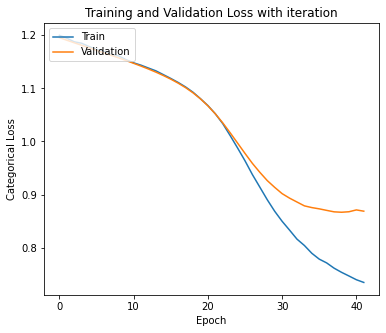

In [11]:
#%% Evaluate the model
#model.load_weights(BW_Tall)  # Load the model weights with the best validation loss

val_ACC     = model.evaluate(X_valid, to_categorical(Y_valid))
train_ACC   = model.evaluate(X_train, to_categorical(Y_train))

# Evaluate different performance metrics
y_pred      = np.argmax(model.predict(X_valid),axis=1) 
F_score     = f1_score(Y_valid, y_pred, average="weighted")
P_score     = precision_score(Y_valid, y_pred, average="weighted")
R_score     = recall_score(Y_valid, y_pred, average="weighted")

print((val_ACC, F_score, P_score, R_score))



plt.figure(figsize=(6, 5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Training and Validation Loss with iteration')
plt.ylabel('Categorical Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Visualizing the CNN model

Implement the 3 different methods of explaining the CNN model


### Method 1: Occlusion Method
Find the change in performance for the model by occluding each channels. Identify the relevance for each of the channels

In [12]:
occlusion_acc_change               = np.zeros((ch,1))
Location                           = np.where(Y_valid == 1)[0] # Eyes closed data  
validation_acc                     = model.evaluate(X_valid[Location].copy(), to_categorical(Y_valid[Location]))[1]                                                       
for i in range(ch): 
    temp_data                      = X_valid[Location].copy()
    temp_data[:,:,i,:]             = 0.
    occlusion_acc_change[i]                =  model.evaluate(temp_data, to_categorical(Y_valid[Location]))[1] - validation_acc    


2176/2176 [==============================] - 0s 129us/step


Visualize the output of the occlusion method. The blue section corresponds to the channel which has the most relevance for correctly predicting the classes

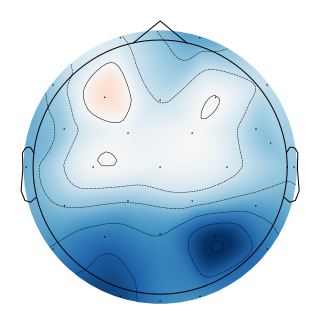

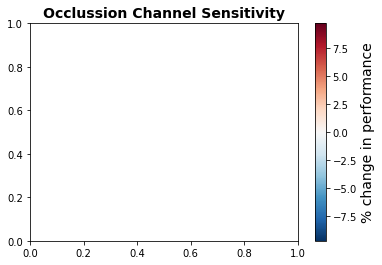

In [13]:
# Generate the topoplot to indicate the channel occlusion sensitivity for the model

 

fig          = plt.figure(figsize=(6, 5))
ax           = fig.add_subplot(111)
im, cn       = mne.viz.plot_topomap(occlusion_acc_change[:,0]*100, chanlocs,sphere = np.max(chanlocs)-0.02 )
cbar         = plt.colorbar(im)
plt.title('Occlussion Channel Sensitivity', fontsize = 14, fontweight = 'bold')
cbar.set_label('% change in performance', rotation = 90, fontsize = 14)


### Method 2: Activation Maximization
 Generates the model input that maximizes the output of all filter_indices in the given layer_idx ( output layer units corresponds to each class)

In [34]:
# Layers to visualize
layer_idx                          = utils.find_layer_idx(model, 'Allout') # identify the layer by the name
model.layers[layer_idx].activation = activations.linear # Change the softmax activation function with linear
model                              = utils.apply_modifications(model)

Maximized_input                    = []
for iteration in range(5): # Repeat 10 times
    for output_idx in np.arange(2):  
            max_input              = visualize_activation(model, # The trained model
                                                            -1,
                                                            tv_weight      = 1.,  # The weight param for TotalVariation regularization loss
                                                            lp_norm_weight = 0.,  # The weight param for LPNorm regularization loss
                                                            act_max_weight = 1., # The weight param for ActivationMaximization loss
                                                            filter_indices = output_idx, # filter indices within the layer to be maximized
                                                            input_range    = (-1.,1.),   # This is used to rescale the final optimized input to the given range
                                                            max_iter       = 200,        # number of iterations to run
                                                            verbose        = True)       # whether to print details during the iterations
            Maximized_input.append(max_input)

print('Activation Maximization computation done')     

Iteration: 1, named_losses: [('ActivationMax Loss', 0.45272753), ('TV(2.0) Loss', 0.038408533)], overall loss: 0.4911360740661621
Iteration: 2, named_losses: [('ActivationMax Loss', 28.08296), ('TV(2.0) Loss', 31.6279)], overall loss: 59.71086120605469
Iteration: 3, named_losses: [('ActivationMax Loss', 14.23345), ('TV(2.0) Loss', 16.984564)], overall loss: 31.218013763427734
Iteration: 4, named_losses: [('ActivationMax Loss', 11.656661), ('TV(2.0) Loss', 20.226782)], overall loss: 31.883441925048828
Iteration: 5, named_losses: [('ActivationMax Loss', 10.155891), ('TV(2.0) Loss', 9.215207)], overall loss: 19.371097564697266
Iteration: 6, named_losses: [('ActivationMax Loss', 10.51247), ('TV(2.0) Loss', 9.144558)], overall loss: 19.657028198242188
Iteration: 7, named_losses: [('ActivationMax Loss', 8.416348), ('TV(2.0) Loss', 7.4865184)], overall loss: 15.90286636352539
Iteration: 8, named_losses: [('ActivationMax Loss', 7.8123307), ('TV(2.0) Loss', 7.359712)], overall loss: 15.17204284

Generate the outputs of the activation maximization method. <br>

Occlusion sensitivity is model independent approach where it depends on the input being fed into the models and how the model prioritizes each of the channels. AM on the otherhand, is a model specific method wherein we generate the ideal input which maximizes the prediction probability to belong to a particular class of interest. 

First we evaluate whether the model was indeed able to learn the topoplot distribution using this approach. <br>

Then we check whether the model understood that alpha power was indeed the most relevant feature to discriminate the classes. We do that by computing the power spectral density of the generate inputs and compare across the classes.





/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1773: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  .format(nperseg, input_length))


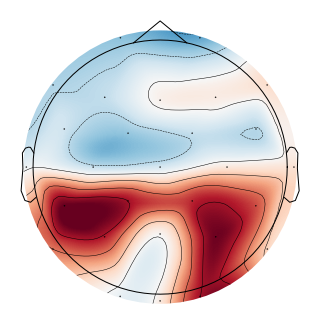

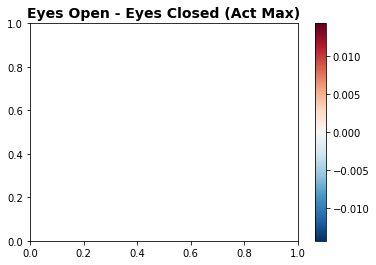

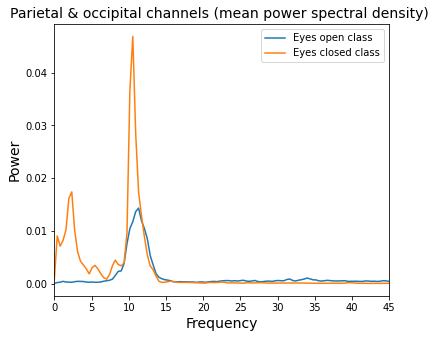

In [35]:
# Compute PSD from the maximized input generated above from each of the classes
# Plot the PSD and the topoplot for alpha band power
NFFT           = 256
PSD          = np.zeros((len(Maximized_input), NFFT//2+1,ch) )  
for i in range(len(Maximized_input)):
    for chan in range(ch):
        freqs, psd    = signal.welch(Maximized_input[i][:,chan,0], fs=100., window='hann', nfft=NFFT)
        PSD[i,:,chan] = psd




# Extract alpha power
alpha_freq   = np.where(np.logical_and(freqs>=8 , freqs < 13))[0]
pow_c0_alpha =     np.mean(np.mean(PSD[::2,alpha_freq,:], axis=1), axis=0) # every other element belong to the same class
pow_c1_alpha =     np.mean(np.mean(PSD[1::2,alpha_freq,:], axis=1), axis=0)

# Generate the topoplot distribution of power difference in alpha (inputs for each class generated by AM method)
 
fig          = plt.figure(figsize=(6, 5))
im, cn       = mne.viz.plot_topomap(pow_c1_alpha - pow_c0_alpha, chanlocs,sphere = np.max(chanlocs)-0.02 )
plt.title('Eyes Open - Eyes Closed (Act Max)', fontsize = 14, fontweight = 'bold')
cbar         = plt.colorbar(im)



# Compute the psd in the parietal occipital region
PSD_c0_mean  =     np.mean(np.mean(PSD[::2,:,-8:], axis=0), axis=1) # Last 8 channels belong to parietal and occipital channels
PSD_c1_mean  =     np.mean(np.mean(PSD[1::2,:,-8:], axis=0), axis=1)


# Generate the mean PSD for the parietal occipital channels
fig          = plt.figure(figsize=(6, 5))
plt.plot(freqs, (PSD_c0_mean))
plt.plot(freqs, (PSD_c1_mean))
plt.xlim([0,45])
plt.title('Parietal & occipital channels (mean power spectral density) ', fontsize = 14)
plt.xlabel('Frequency', fontsize = 14)
plt.ylabel('Power', fontsize = 14)
plt.legend(['Eyes open class','Eyes closed class'])



### Method 3: Grad-CAM
Generates a gradient based class activation map (grad-CAM) that maximizes the outputs of filter_indices in layer_idx. We will take the same sample image and get the gradCAM corresponding to the last convolution layer to get the heatmap. 

For the sake of the tutorial, we are performing this on 12 examples randomly sampled from the correctly identified data points
 

In [16]:
# Select correctly identified examples of eyes closed
Location                           = np.where(np.logical_and(y_pred == Y_valid,  Y_valid == 1))[0]       
order                              = np.arange(len(Location))
np.random.shuffle(order)
Location                           = Location[order]


Location_0                         = np.where(np.logical_and(y_pred == Y_valid,  Y_valid == 0))[0]       
order                              = np.arange(len(Location_0))
np.random.shuffle(order)
Location_0                         = Location_0[order]

         
# Layers to estimate gradCAM based on            
layer_idx1                         = utils.find_layer_idx(model, 'Temporal_pool_L3') # # identify the layer by the name 

# Initialize the variables
p, num_examples                    = 0, 12  # num_examples : total number of examples to obtain CAM for 
gradCAMs                           = np.zeros((num_examples*2, time_samples, ch))     

for iteration in range(num_examples):     
    for output_idx in np.arange(2): 
        if output_idx == 0:
            seed                    = X_valid[Location_0[iteration]] # 
        else:
            seed                    = X_valid[Location[iteration]] # 
            
        gradCAMs[p]                 = visualize_cam(model,  # The trained model
                                                   -1, # The layer index whose filters needs to be visualized.
                                                   filter_indices        = output_idx, # filter indices within the layer to be maximized. 
                                                   penultimate_layer_idx = layer_idx1, # The pre-layer to layer_idx whose feature maps should be used to compute gradients wrt filter output. 
                                                   seed_input            = seed) #  The input image for which activation map needs to be visualized.
        p=p+1        

print('GradCAM computation done')

GradCAM computation done


Check whether using gradCAM method, we can identify the most relevant channels. Plot the topoplot based on the mean gradCAM across each channels

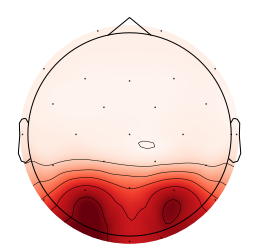

Text(0.5, 1.0, 'Eyes Closed Class GradCAM')

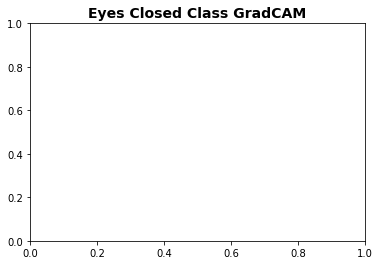

In [17]:
rcParams['figure.figsize'] = 6, 4
fig          = plt.figure()
gradcam_c1   = np.mean(np.mean(gradCAMs[1::2], axis = 0), axis = 0)
ax           = fig.add_subplot(111)
im, cn       = mne.viz.plot_topomap(gradcam_c1, chanlocs,sphere = np.max(chanlocs)-0.02 )
plt.title('Eyes Closed Class GradCAM', fontsize = 14, fontweight = 'bold')
#cbar         = plt.colorbar(im)
#cbar.set_label('Importance score', rotation = 90, fontsize = 14)



In [18]:
#%%  Save all the outputs for exploring more locally 
sio.savemat('/content/drive/My Drive/uhbmi_workshop/Visualized_outputs.mat', {'Maximized_input':Maximized_input,'gradCAMs':gradCAMs, 'occlusion_acc_change':occlusion_acc_change })

# Save the scores and training history
sio.savemat('/content/drive/My Drive/uhbmi_workshop/Score.mat', {'val_loss':hist.history['val_loss'],
                                'val_acc':hist.history['val_accuracy'],'loss':hist.history['loss'],
                                'acc':hist.history['accuracy'],  'val_ACC':val_ACC,
                                'train_ACC':train_ACC,
                                'F_score':F_score ,'P_score':P_score, 'R_score':R_score })  



##Extra: 
Check how gradCAM works when you have a long window with both classes in it. Here we feed an input of 5 second long window with the first 2.5 seconds belonging to eyes closed condition and the last 2.5 seconds belonging to eyes open condition. We then compute the gradCAM for this input and ask the model which part in this data the model believes to most contribute to eyes closed condition. 

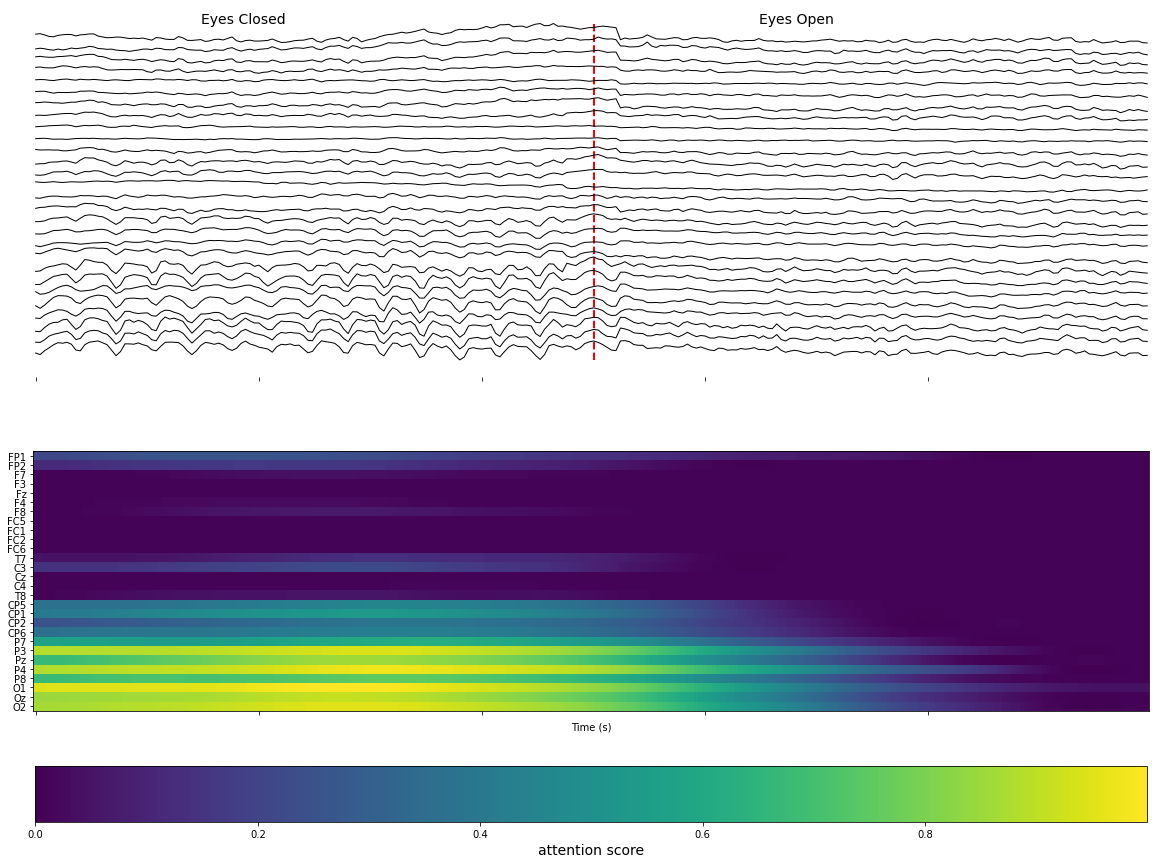

In [19]:

chanlocs_name =  ['FP1',	'FP2',	'F7',	'F3',	'Fz',	
                'F4',	'F8',	'FC5',	'FC1',	'FC2',	
                'FC6',	'T7',	'C3',	'Cz',	'C4',	
                'T8',	'CP5',	'CP1',	'CP2',	'CP6',	
                'P7',	'P3',	'Pz',	'P4',	'P8',	
                'O1',	'Oz',	'O2']

test         = Loaded_data['test' ].T 
test_copy    = test.copy()
test         = np.reshape(test, (1, test.shape[0], test.shape[1], 1))/a # Normalize with the same constant as before


# Adding offset for plotting purpose
offset       = np.max(abs(test_copy))
for i in range(ch):
    test_copy[:,i] =  test_copy[:,i]-(i*offset)  
     
# Generate gradCAM for continous data including both classes

cont_data    = visualize_cam(model,  # The trained model
                            -1, # The layer index whose filters needs to be visualized.
                            filter_indices        = 1, # filter indices within the layer to be maximized. 
                            penultimate_layer_idx = layer_idx1, # The pre-layer to layer_idx whose feature maps should be used to compute gradients wrt filter output. 
                            seed_input            = test) #  The input image for which activation map needs to be visualized.

# Plot the EEG time series with offset
plt.figure(figsize=(20, 15))
ax1          = plt.subplot(211)
plt.plot([time_samples/2, time_samples/2],[np.min(test_copy)-1, np.max(test_copy)+1],color='r',linewidth=2,linestyle='dashed')
plt.plot(test_copy,color = 'k',linewidth = 1)
plt.text(int(time_samples*0.15), np.max(test_copy) + 0.1,'Eyes Closed', fontsize = 14)
plt.text(int(time_samples*0.65), np.max(test_copy) + 0.1,'Eyes Open', fontsize = 14)

plt.box(False)
frame1 = plt.gca()
frame1.axes.yaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticks([])
frame1.axes.xaxis.set_ticklabels([])

# Show the gradcam heatmap
ax2          = plt.subplot(212 ,sharex = ax1)
im           = plt.imshow(cont_data.T, aspect='auto')
plt.yticks(np.arange(0,28,1))
plt.xlabel('Time (s)')
frame2       = plt.gca()
frame2.axes.yaxis.set_ticklabels(chanlocs_name)
cbar         = plt.colorbar(im, orientation="horizontal")
cbar.set_label('attention score', fontsize = 14)